
### Offensive language detection model


In [1]:
import csv
import copy

from warnings import filterwarnings
filterwarnings('ignore')

#loading the training data

X_txt = []
y = []

#load the training datasets to two lists (X_txt_train will be a list of strings; y_train)
with open("./train.tsv", encoding="utf8") as in_file: #added utf8 encoding to avoid error
    myCSV = csv.reader(in_file, delimiter = "\t", quoting = csv.QUOTE_NONE)
    
    for row in myCSV:
        X_txt.append(row[-2])
        y.append(row[-1])
        
print(len(X_txt), len(y))

10592 10592


In [2]:
# Print example of some of the tweets
import pandas as pd

pd.set_option("display.max_colwidth", None)

df = {"Tweets":X_txt,'Class':y}
df = pd.DataFrame(df)
df.head()

,Tweets,Class
0,@USER She should ask a few native Americans what their take on this is.,UNT
1,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,TIN
2,Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT,NOT
3,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",UNT
4,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT


Text(0.5, 1.0, 'Bar Chart of Classes')

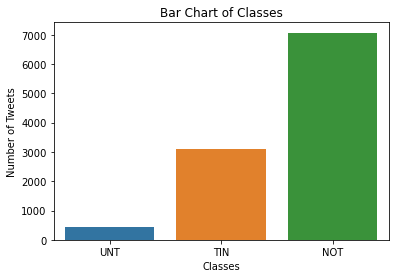

In [3]:
# Bar plot for the distibution of classes

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df.Class)
plt.xlabel('Classes');
plt.ylabel('Number of Tweets')
plt.title('Bar Chart of Classes')

### Basic Linear Model Raw Test Data

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
np.random.seed(42)
import random
random.seed(42)

#Create Numpy Arrays for x and y data
X_txt = np.array(X_txt)
y = np.array(y)

#split into train and validation using train test split
X_txt_train, X_txt_val, y_train, y_val = train_test_split(X_txt, y, test_size=0.2, random_state=42)

vec1 = CountVectorizer(ngram_range = (1,1), stop_words= "english")

X_train1 = vec1.fit_transform(X_txt_train)
X_val1 = vec1.transform(X_txt_val)
svc = LinearSVC()
params = {"C":[0.001, 0.01, 0.1, 1.0, 10]}

clf = GridSearchCV(svc, params, cv = 5, scoring = "f1_macro")

#fitting the model
clf.fit(X_train1, y_train)

# Get the score from the GridSearchCV "best score"
validation_score = clf.best_score_ 
print("Validation F1: {:.4f}".format(validation_score))

#predictions on validation set
svm_val_preds = clf.predict(X_val1)

report = classification_report(y_val, svm_val_preds )

precision = precision_score(y_val, svm_val_preds, average="macro") 
recall = recall_score(y_val, svm_val_preds, average = "macro")
f1 = f1_score(y_val, svm_val_preds, average = "macro")
f1_micro = f1_score(y_val, svm_val_preds, average = "micro")

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1: {:.4f}".format(f1))
print("F1 micro: {:.4f}".format(f1_micro))
print(report)

Validation F1: 0.4652
Precision: 0.4983
Recall: 0.4737
F1: 0.4803
F1 micro: 0.6928
              precision    recall  f1-score   support

         NOT       0.78      0.81      0.80      1409
         TIN       0.52      0.51      0.52       617
         UNT       0.20      0.10      0.13        93

    accuracy                           0.69      2119
   macro avg       0.50      0.47      0.48      2119
weighted avg       0.68      0.69      0.69      2119



In [5]:
print(X_train1.shape, X_val1.shape)

(8473, 14538) (2119, 14538)


In [6]:
#Confusion matrix
conf = confusion_matrix(y_val, svm_val_preds )

plt.show()
pd.crosstab(y_val, svm_val_preds, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,NOT,TIN,UNT,All
Actual,,,,
NOT,1142,250,17,1409
TIN,280,317,20,617
UNT,38,46,9,93
All,1460,613,46,2119


### Preprocessing and New features function

In [7]:

import re
class NewFeatures():
    def __init__(self):
        
        self.offensive_words = set()
        with open('bad_words.txt', encoding = 'utf-8') as iFile:
            for row in iFile:
                self.offensive_words.add(row.strip())
        
        self.int_words = set()
        with open('int-words.txt', encoding = 'utf-8') as iFile:
            for row in iFile:
                self.int_words.add(row.strip())
        
        self.pronouns= set(["he", "she", "it", "its", "it's", "him", "her", "his","they","their","we", "our","i","you","your","my","mine","yours","ours","all", "", "he", "her", "hers", "herself", "him", "himself", "his", "", "", "it", "its", "itself", "many", "me mine", "more", "most", "much", "my", "myself", "neither", "no one", "nobody", "none", "nothing", "one", "other", "others", "our", "ours", "ourselves", "several", "she", "some", "somebody", "someone", "something", "that", "their", "theirs", "them", "themselves", "these", "they", "this", "those", "us", "we", "which",  "who", "whoever", "whom", "whose", "you", "your", "yours", "yourself", "yourselves"])

                
    # Cleaning data - Remove the noises from the data
    def remove_noises(self, sentence):
        no_noise_list = []
        no_noise_count = 0
        noises = ['URL', '@USER', '\'ve', 'n\'t', '\'s', '\'m']

        for noise in noises:
            sentence = sentence.replace(noise, '')
        
        sentence = (re.sub(r'[^a-zA-Z]', ' ', sentence))        
        
        return sentence.lower()

     # count the number of exclamation words
    def count_exclamation_marks(self, sentence):
        num_excl_marks = 0
        for char in list(sentence):   
            if char == "!":
                num_excl_marks += 1
        return num_excl_marks

     # count the number of capital words
    def count_caps(self, sentence):
        capitalized_words = 0
        for word in sentence.split():
            if word.isupper():
                capitalized_words += 1  
        return capitalized_words
    
    # count the number of words in title case
    def find_names(self, sentence):
        names = 0
        for word in sentence.split():
            if word.istitle():
                names += 1
        return names
        
    # count ellipses
    def count_ellipses(self, sentence):
        num_ellipses = 0
        for word in sentence.lower().split():
            if word in ('...'):
                num_ellipses += 1
        return num_ellipses
 
    #Count twitter objects: count of URLs, @ Mentions, # Hashtag mentions
    
    def count_twitter_objs(self, sentence): 
        """
        Returns counts of URLs, mentions, and hashtags.
        """
        twitter_obj_features = []

        giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        mention_regex = '@[\w\-]+'
        hashtag_regex = '#[\w\-]+'
        tweet_features = re.sub(giant_url_regex, 'URL', sentence)
        tweet_features = re.sub(mention_regex, 'MENTION', tweet_features)
        tweet_features = re.sub(hashtag_regex, 'HASHTAG', tweet_features)
        
        return([tweet_features.count('URL'),tweet_features.count('MENTION'),tweet_features.count('HASHTAG')])
    #lexicon features
    def count_off_words(self, sentence):
        num_off_words = 0
        for word in sentence.lower().split():
            if word in self.offensive_words:
                num_off_words += 1

        num_int_words = 0
        for word in sentence.lower().split():
            if word in self.int_words:
                num_int_words += 1
        
        num_pron_words = 0
        for word in sentence.lower().split():
            if word in self.pronouns:
                num_pron_words += 1 

        return [num_off_words,num_int_words,num_pron_words]

### Cleaning the datset

In [8]:
#Cleaning dataset
new_cls = NewFeatures()

clean_txt_train = []
clean_txt_val = []

for tweet in X_txt_train:
    x = new_cls.remove_noises(tweet)
    clean_txt_train.append(x.strip())

for tweet in X_txt_val:
    x = new_cls.remove_noises(tweet)
    clean_txt_val.append(x.strip()) 


In [9]:
# Print examples of claened tweets
random.seed(42)
pd.set_option("display.max_colwidth", None)

df = {"Tweets":X_txt_train,"Clean Tweets":clean_txt_train}
df = pd.DataFrame(df)
df.head()

,Tweets,Clean Tweets
0,@USER @USER @USER You are grossly misinterpreting who is against this. People across all parties condemn this action. Look no further than Bill Davis and Brian Mulroney to see that even conservatives think this is a horrible decision.,you are grossly misinterpreting who is against this people across all parties condemn this action look no further than bill davis and brian mulroney to see that even conservatives think this is a horrible decision
1,@USER Children should be seen and not heard!!!,children should be seen and not heard
2,"@USER They've morphed into Antifa. Antifa gets better coverage and that all important Soros cash! ie: I'm so upset about you know racist stuff and Trump and children in cages and everything the like that, ya know?""""",they morphed into antifa antifa gets better coverage and that all important soros cash ie i so upset about you know racist stuff and trump and children in cages and everything the like that ya know
3,@USER @USER she is one,she is one
4,@USER @USER @USER @USER So if Paul Golding turned up for a job at the BBC you'd let him work for them?,so if paul golding turned up for a job at the bbc you d let him work for them


In [10]:
#Creating List of Lists for New Features

new_cls = NewFeatures()

# Loading feature 1 - Exclamation marks

X_excl_train = []
X_excl_val = []

for tweet in X_txt_train:
    X_excl_train.append([new_cls.count_exclamation_marks(tweet)])

for tweet in X_txt_val:
    X_excl_val.append([new_cls.count_exclamation_marks(tweet)])
    
#Loading feature 2 - count capitalized words
X_caps_train = []
X_caps_val = []

for tweet in X_txt_train:
    X_caps_train.append([new_cls.count_caps(tweet)])

for tweet in X_txt_val:
    X_caps_val.append([new_cls.count_caps(tweet)])  

# Loading feature 3 - Names

X_names_train = []
X_names_val = []

for tweet in X_txt_train:
    X_names_train.append([new_cls.find_names(tweet)])
    
for tweet in X_txt_val:
    X_names_val.append([new_cls.find_names(tweet)])
    
# Loading feature 4 - Ellipses

X_ellipses_train = []
X_ellipses_val = []

for tweet in X_txt_train:
    X_ellipses_train.append([new_cls.count_ellipses(tweet)])

for tweet in X_txt_val:
    X_ellipses_val.append([new_cls.count_ellipses(tweet)])   
    
    
#Loading feature 5 - count twitter object features

X_twitter_obj_train = []
X_twitter_obj_val = []

for tweet in X_txt_train:
    X_twitter_obj_train.append(new_cls.count_twitter_objs(tweet))

for tweet in X_txt_val:
    X_twitter_obj_val.append(new_cls.count_twitter_objs(tweet))

#Loading feature 6 - count number of offensive words 
# from cleaned twitter data

X_offensive_train = []
X_offensive_val = []

for tweet in clean_txt_train:
    X_offensive_train.append(new_cls.count_off_words(tweet))

for tweet in clean_txt_val:
    X_offensive_val.append(new_cls.count_off_words(tweet))

In [11]:
# Adding features to dataset

import scipy.sparse as sp
from scipy.sparse import hstack

import numpy as np
np.random.seed(42)
import random
random.seed(42)


X_excl_train = np.array(X_excl_train)
X_excl_val = np.array(X_excl_val)


X_names_train = np.array(X_names_train)
X_names_val = np.array(X_names_val)


X_ellipses_train = np.array(X_ellipses_train)
X_ellipses_val = np.array(X_ellipses_val)


X_caps_train = np.array(X_caps_train)
X_caps_val = np.array(X_caps_val)


X_twitter_obj_train = np.array(X_twitter_obj_train)
X_twitter_obj_val = np.array(X_twitter_obj_val)


X_offensive_train = np.array(X_offensive_train)
X_offensive_val = np.array(X_offensive_val)

#Prepare for Vectorization

vec = CountVectorizer(ngram_range = (1,2), stop_words= "english", max_df = 0.9, min_df = 5)  

X_train = vec.fit_transform(clean_txt_train) 
X_val = vec.transform(clean_txt_val)

X_train = hstack([X_train, X_excl_train])
X_val = hstack([X_val, X_excl_val])

# X_train = hstack([X_train, X_names_train])
# X_val = hstack([X_val, X_names_val]) 

X_train = hstack([X_train, X_caps_train])
X_val = hstack([X_val, X_caps_val])

# X_train = hstack([X_train, X_ellipses_train])
# X_val = hstack([X_val, X_ellipses_val]) 

X_train = hstack([X_train, X_twitter_obj_train])
X_val = hstack([X_val, X_twitter_obj_val])

X_train = hstack([X_train, X_offensive_train])
X_val = hstack([X_val, X_offensive_val])

In [12]:
print(X_train.shape, X_val.shape)

(8473, 3069) (2119, 3069)


### Linear Classifier with new features

In [13]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

# Initialize the classifier LinearSVC 
svc = LinearSVC()

# Create the params with the C values
params = {"C": [0.01, 0.1, 1., 10, 100], "class_weight" : ["balanced"]}

# Initialize GridSearchCV
clf_svc = GridSearchCV(svc, params, cv = 5) 


clf_svc.fit(X_train, y_train)

svm_offensive = clf_svc.predict(X_val) 

validation_score = clf_svc.best_score_
precision_2 = precision_score(svm_offensive, y_val, average = 'macro') 
recall_2 = recall_score(svm_offensive, y_val, average = 'macro')
f1_2 = f1_score(svm_offensive, y_val, average = 'macro')
f1_2_micro = f1_score(svm_offensive, y_val, average = 'micro')

report = classification_report(y_val, svm_offensive, digits = 4 )

print("Validation F1: {:.4f}".format(validation_score))
print("Precision: {:.4f}".format(precision_2))
print("Recall: {:.4f}".format(recall_2))
print("F1 Macro: {:.4f}".format(f1_2))
print("F1 Micro: {:.4f}".format(f1_2_micro))
print(report)

Validation F1: 0.7218
Precision: 0.5342
Recall: 0.5848
F1 Macro: 0.5515
F1 Micro: 0.7338
              precision    recall  f1-score   support

         NOT     0.7833    0.8928    0.8345      1409
         TIN     0.6140    0.4408    0.5132       617
         UNT     0.3571    0.2688    0.3067        93

    accuracy                         0.7338      2119
   macro avg     0.5848    0.5342    0.5515      2119
weighted avg     0.7153    0.7338    0.7178      2119



In [14]:
#Confusion matrix
conf = confusion_matrix(y_val, svm_offensive)

plt.show()
pd.crosstab(y_val, svm_offensive, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,NOT,TIN,UNT,All
Actual,,,,
NOT,1258,139,12,1409
TIN,312,272,33,617
UNT,36,32,25,93
All,1606,443,70,2119


### Sgd Classifier with new features

In [15]:

import scipy.sparse as sp
from scipy.sparse import hstack
from sklearn.linear_model import SGDClassifier
import numpy as np
np.random.seed(42)
import random
random.seed(42)


from warnings import filterwarnings
filterwarnings('ignore')


# Initialize the classifier LinearSVC 
sgd = SGDClassifier()

# Create the params with the C values
params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'penalty': ['l1','l2'],
    'shuffle':[True, False],
    'n_jobs': [-1],
    'class_weight':['balanced']
}

# Initialize GridSearchCV
clf_sgd = GridSearchCV(sgd, params, cv = 5) 


clf_sgd.fit(X_train, y_train)

sgd_offensive = clf_sgd.predict(X_val) 

validation_score = clf_sgd.best_score_
precision_3 = precision_score(sgd_offensive, y_val, average = 'macro') 
recall_3 = recall_score(sgd_offensive, y_val, average = 'macro')
f1_3 = f1_score(sgd_offensive, y_val, average = 'macro')
f1_3_micro = f1_score(sgd_offensive, y_val, average = 'micro')

report_sgd = classification_report(y_val, sgd_offensive, digits = 4 )

print("Validation F1: {:.4f}".format(validation_score))
print("Precision: {:.4f}".format(precision_3))
print("Recall: {:.4f}".format(recall_3))
print("F1: {:.4f}".format(f1_3))
print("F1 Micro: {:.4f}".format(f1_3_micro))
print(report_sgd)

Validation F1: 0.7049
Precision: 0.4707
Recall: 0.5832
F1: 0.4936
F1 Micro: 0.7117
              precision    recall  f1-score   support

         NOT     0.7531    0.8964    0.8185      1409
         TIN     0.5631    0.3760    0.4509       617
         UNT     0.4333    0.1398    0.2114        93

    accuracy                         0.7117      2119
   macro avg     0.5832    0.4707    0.4936      2119
weighted avg     0.6838    0.7117    0.6848      2119



In [16]:
#Confusion matrix
conf = confusion_matrix(y_val, sgd_offensive)

plt.show()
pd.crosstab(y_val, sgd_offensive, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,NOT,TIN,UNT,All
Actual,,,,
NOT,1263,140,6,1409
TIN,374,232,11,617
UNT,40,40,13,93
All,1677,412,30,2119


### Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import numpy as np
np.random.seed(42)
import random
random.seed(42)

from warnings import filterwarnings
filterwarnings('ignore')


# Initialize the classifier LinearSVC 
rf = RandomForestClassifier()

# Create the params with the C values
params = {'n_estimators': [100, 200]}

# Initialize GridSearchCV
clf_rf = GridSearchCV(rf, params, cv = 5) 


clf_rf.fit(X_train, y_train)

rf_offensive = clf_rf.predict(X_val) 

validation_score = clf_rf.best_score_
precision_4 = precision_score(rf_offensive, y_val, average = 'macro') 
recall_4 = recall_score(rf_offensive, y_val, average = 'macro')
f1_4 = f1_score(rf_offensive, y_val, average = 'macro')
f1_4_micro = f1_score(rf_offensive, y_val, average = 'micro')

report_rf = classification_report(y_val, rf_offensive )

print("Validation F1: {:.4f}".format(validation_score))
print("Precision: {:.4f}".format(precision_4))
print("Recall: {:.4f}".format(recall_4))
print("F1: {:.4f}".format(f1_4))
print("F1 Micro: {:.4f}".format(f1_4_micro))
print(report_rf)

Validation F1: 0.7399
Precision: 0.4591
Recall: 0.5393
F1: 0.4714
F1 Micro: 0.7249
              precision    recall  f1-score   support

         NOT       0.76      0.91      0.83      1409
         TIN       0.59      0.40      0.48       617
         UNT       0.26      0.06      0.10        93

    accuracy                           0.72      2119
   macro avg       0.54      0.46      0.47      2119
weighted avg       0.69      0.72      0.70      2119



In [18]:
#Confusion matrix
conf = confusion_matrix(y_val, rf_offensive)

plt.show()
pd.crosstab(y_val, rf_offensive, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,NOT,TIN,UNT,All
Actual,,,,
NOT,1281,125,3,1409
TIN,354,249,14,617
UNT,41,46,6,93
All,1676,420,23,2119


### Linear svc with Tfidf Vectorizer

In [19]:

import scipy.sparse as sp
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import numpy as np
np.random.seed(42)
import random
random.seed(42)

from warnings import filterwarnings
filterwarnings('ignore')


#Prepare for Vectorization
tfid = TfidfVectorizer(ngram_range = (1,2), stop_words= "english", min_df = 5, max_df = 0.9)

X_train_tfid = tfid.fit_transform(clean_txt_train) 
X_val_tfid = tfid.transform(clean_txt_val)


# X_train_tfid = hstack([X_train_tfid, X_excl_train])
# X_val_tfid = hstack([X_val_tfid, X_excl_val])

# X_train_tfid = hstack([X_train_tfid, X_names_train])
# X_val_tfid = hstack([X_val_tfid, X_names_val]) 

X_train_tfid = hstack([X_train_tfid, X_caps_train])
X_val_tfid = hstack([X_val_tfid, X_caps_val])

# X_train = hstack([X_train, X_ellipses_train])
# X_val = hstack([X_val, X_ellipses_val]) 

X_train_tfid = hstack([X_train_tfid, X_twitter_obj_train])
X_val_tfid = hstack([X_val_tfid, X_twitter_obj_val])

X_train_tfid = hstack([X_train_tfid, X_offensive_train])
X_val_tfid = hstack([X_val_tfid, X_offensive_val])


# Initialize the classifier LinearSVC 
svc = LinearSVC()

params = {"C": [0.01, 0.1, 1., 10, 100], "class_weight":['balanced']}

# Initialize GridSearchCV
clf_tfid = GridSearchCV(svc,params, cv = 5) 

# "fit" the model  on x_train_w_lex
clf_tfid.fit(X_train_tfid, y_train)

tfid_offensive = clf_tfid.predict(X_val_tfid) 

validation_score = clf_tfid.best_score_
precision_5 = precision_score(tfid_offensive, y_val, average = 'macro') 
recall_5 = recall_score(tfid_offensive, y_val, average = 'macro')
f1_5 = f1_score(tfid_offensive, y_val, average = 'macro')
f1_5_micro = f1_score(tfid_offensive, y_val, average = 'micro')

report_tfidf = classification_report(y_val, tfid_offensive, digits = 4 )

print("Validation F1: {:.4f}".format(validation_score))
print("Precision: {:.4f}".format(precision_5))
print("Recall: {:.4f}".format(recall_5))
print("F1 macro: {:.4f}".format(f1_5))
print("F1 micro: {:.4f}".format(f1_5_micro))
print(report_tfidf)

Validation F1: 0.7189
Precision: 0.5417
Recall: 0.5733
F1 macro: 0.5543
F1 micro: 0.7343
              precision    recall  f1-score   support

         NOT     0.7991    0.8694    0.8328      1409
         TIN     0.6008    0.4976    0.5443       617
         UNT     0.3200    0.2581    0.2857        93

    accuracy                         0.7343      2119
   macro avg     0.5733    0.5417    0.5543      2119
weighted avg     0.7203    0.7343    0.7248      2119



In [20]:
#Confusion matrix
conf = confusion_matrix(y_val, tfid_offensive)

plt.show()
pd.crosstab(y_val, tfid_offensive, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,NOT,TIN,UNT,All
Actual,,,,
NOT,1225,169,15,1409
TIN,274,307,36,617
UNT,34,35,24,93
All,1533,511,75,2119


### DecisionTreeClassifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

import numpy as np
np.random.seed(42)
import random
random.seed(42)

clf_dt = DecisionTreeClassifier() #initialize classifier

clf_dt.fit(X_train_tfid, y_train)

dt_offensive = clf_dt.predict(X_val_tfid) # Get predictions on x_val_tfidf

precision_7 = precision_score(dt_offensive, y_val, average = 'macro') # Get scores using predictions and y_val with the precision_score method
recall_7 = recall_score(dt_offensive, y_val, average = 'macro')
f1_7 = f1_score(dt_offensive, y_val, average = 'macro')
f1_7_micro = f1_score(dt_offensive, y_val, average = 'micro')

report_dt = classification_report(y_val, dt_offensive, digits = 4 )

print("Precision: {:.4f}".format(precision_7))
print("Recall: {:.4f}".format(recall_7))
print("F1 macro: {:.4f}".format(f1_7))
print("F1 micro: {:.4f}".format(f1_7_micro))
print(report_dt)

Precision: 0.4712
Recall: 0.5041
F1 macro: 0.4815
F1 micro: 0.6739
              precision    recall  f1-score   support

         NOT     0.7670    0.7942    0.7803      1409
         TIN     0.4852    0.4797    0.4825       617
         UNT     0.2600    0.1398    0.1818        93

    accuracy                         0.6739      2119
   macro avg     0.5041    0.4712    0.4815      2119
weighted avg     0.6627    0.6739    0.6673      2119



In [22]:
#Confusion matrix
conf = confusion_matrix(y_val, dt_offensive)

plt.show()
pd.crosstab(y_val, dt_offensive, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,NOT,TIN,UNT,All
Actual,,,,
NOT,1119,272,18,1409
TIN,302,296,19,617
UNT,38,42,13,93
All,1459,610,50,2119


### Random forest Classifier with tfidf vectorizer

In [23]:

import scipy.sparse as sp
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import numpy as np
np.random.seed(42)
import random
random.seed(42)


from warnings import filterwarnings
filterwarnings('ignore')


rf = RandomForestClassifier()

# Create the params with the C values
params = {'n_estimators': [100,200, 500]}

# Initialize GridSearchCV
clf_rf = GridSearchCV(rf, params, cv = 5) 


clf_rf.fit(X_train_tfid, y_train)

rf_offensive_tfidf = clf_rf.predict(X_val_tfid) 

validation_score = clf_rf.best_score_
precision_7 = precision_score(rf_offensive_tfidf, y_val, average = 'macro') 
recall_7 = recall_score(rf_offensive_tfidf, y_val, average = 'macro')
f1_7 = f1_score(rf_offensive_tfidf, y_val, average = 'macro')
f1_7_micro = f1_score(rf_offensive_tfidf, y_val, average = 'micro')

report_dt = classification_report(y_val, rf_offensive_tfidf, digits = 4 )

print("Validation F1: {:.4f}".format(validation_score))
print("Precision: {:.4f}".format(precision_7))
print("Recall: {:.4f}".format(recall_7))
print("F1: {:.4f}".format(f1_7))
print("F1 Micro: {:.4f}".format(f1_7_micro))
print(report_dt)

Validation F1: 0.7400
Precision: 0.4529
Recall: 0.5659
F1: 0.4645
F1 Micro: 0.7277
              precision    recall  f1-score   support

         NOT     0.7587    0.9241    0.8333      1409
         TIN     0.6057    0.3809    0.4677       617
         UNT     0.3333    0.0538    0.0926        93

    accuracy                         0.7277      2119
   macro avg     0.5659    0.4529    0.4645      2119
weighted avg     0.6955    0.7277    0.6943      2119



In [24]:
#Confusion matrix
conf = confusion_matrix(y_val, rf_offensive_tfidf)

plt.show()
pd.crosstab(y_val, rf_offensive_tfidf, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,NOT,TIN,UNT,All
Actual,,,,
NOT,1302,104,3,1409
TIN,375,235,7,617
UNT,39,49,5,93
All,1716,388,15,2119


#### Examples of false positive and false negative

In [26]:

# df = {'Raw Tweet':X_txt_train, "Clean Tweet": clean_txt_train}
# df = pd.DataFrame(df)
# df.head()
import numpy as np
np.random.seed(100)

pd.set_option("display.max_colwidth", None)

df = {"Tweets":X_txt_val,'True Label':y_val, "SVM Predicted": svm_val_preds, "SVM w/NF Predicted":svm_offensive, "SGD Predicted" :sgd_offensive, "RF w/NF Predicted":rf_offensive, "DT Predicted":dt_offensive, "Clean Tweets":clean_txt_val}
df = pd.DataFrame(df)
df.sample(n=5)


,Tweets,True Label,SVM Predicted,SVM w/NF Predicted,SGD Predicted,RF w/NF Predicted,DT Predicted,Clean Tweets
1537,@USER @USER @USER @USER Awesome🔥🔥🔥🔥❤❤❤❤,NOT,NOT,NOT,NOT,NOT,NOT,awesome
29,@USER Most Americans find any of this hard to believe...30 plus yrs later. Another Justice Thomas hit job by the media and liberals?,NOT,NOT,NOT,NOT,NOT,NOT,most americans find any of this hard to believe plus yrs later another justice thomas hit job by the media and liberals
427,@USER He is a coward.,TIN,TIN,NOT,NOT,TIN,TIN,he is a coward
555,@USER Hello... the problem with more gun control is the only people that guns are being taken away from or ‘controlled’ as you say are people like me who has the legal right to carry a gun. So before you continue to scream gun control... look at who it would affect.,NOT,TIN,TIN,TIN,TIN,NOT,hello the problem with more gun control is the only people that guns are being taken away from or controlled as you say are people like me who has the legal right to carry a gun so before you continue to scream gun control look at who it would affect
1405,@USER I AM FUCKING SO FUCKING HAPPY,UNT,UNT,UNT,UNT,TIN,UNT,i am fucking so fucking happy


### Replace the prediction value to test values
#### Load test data

In [27]:
# tolist function
X_txt_test = []
#load the training datasets to two lists (X_txt_train will be a list of strings; y_train)
with open("./test.tsv", encoding="utf8") as in_file: #added utf8 encoding to avoid error
    myCSV = csv.reader(in_file, delimiter = "\t", quoting = csv.QUOTE_NONE)
    for row in myCSV:
        X_txt_test.append(row[-2])
print(len(X_txt_test))

2648


#### Clean test data

In [28]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)


#cleaning the dataset
clean_txt_test = []

for tweet in X_txt_test:
    x = new_cls.remove_noises(tweet)
    clean_txt_test.append(x)



##### Feature Engineering and preparation for prediction

In [29]:
#Feature Engineering

X_excl_test = []
for tweet in X_txt_test:
    X_excl_test.append([new_cls.count_exclamation_marks(tweet)])

X_caps_test = []
for tweet in X_txt_test:
    X_caps_test.append([new_cls.count_caps(tweet)])
    
X_twitter_obj_test = []
for tweet in X_txt_test:
    X_twitter_obj_test.append(new_cls.count_twitter_objs(tweet))
    
X_offensive_test = []
for tweet in clean_txt_test:
    X_offensive_test.append(new_cls.count_off_words(tweet))

In [30]:
# change to numpay array

X_excl_test = np.array(X_excl_test)
X_caps_test = np.array(X_caps_test)
X_twitter_obj_test = np.array(X_twitter_obj_test)
X_offensive_test = np.array(X_offensive_test)


In [31]:
#Vcetorization

X_test = vec.transform(clean_txt_test)
print(X_test.shape)
X_test = hstack([X_test, X_excl_test])
X_test = hstack([X_test, X_caps_test])
X_test = hstack([X_test, X_twitter_obj_test])
X_test = hstack([X_test, X_offensive_test])

print(X_test.shape)

(2648, 3061)
(2648, 3069)


#### Prediction on test data

In [32]:
test_preds = clf_svc.predict(X_test)

In [33]:
test_preds[:20]

array(['NOT', 'NOT', 'NOT', 'NOT', 'NOT', 'TIN', 'NOT', 'NOT', 'NOT',
       'NOT', 'NOT', 'NOT', 'NOT', 'TIN', 'NOT', 'TIN', 'NOT', 'NOT',
       'TIN', 'NOT'], dtype='<U3')

### Add predictions to test tweets and export as tsv

In [34]:
test_df = pd.read_csv("./test.tsv", delimiter="\t", header= None)

In [35]:
test_file = 'test.tsv'
df_test= pd.read_csv(test_file, sep='\t', header=None)
df_test.columns = ["id","Tweet", "fake_Class"]
df_test.drop(['fake_Class'], axis = 1, inplace= True)
df_test.head()

,id,Tweet
0,41567,@USER Nancy Lee Grahn You Are Awesome! I have been a fan since Santa Barbara!! Alex Davis also Rocks!!!!! Thank you !!!
1,19123,@USER She is a Skrull. Enemy of The Kree. The Kree are who gave Carol her powers and whose uniform she is wearing in the first few moments of the trailer.
2,79672,@USER @USER @USER @USER @USER @USER @USER Except you kind of are when it comes to gun control
3,29055,@USER @USER @USER You are so beautiful♡
4,32479,@USER This is what happens when liberals get in control


In [36]:
df_test['predicted_class'] =  test_preds
df_test.head()

,id,Tweet,predicted_class
0,41567,@USER Nancy Lee Grahn You Are Awesome! I have been a fan since Santa Barbara!! Alex Davis also Rocks!!!!! Thank you !!!,NOT
1,19123,@USER She is a Skrull. Enemy of The Kree. The Kree are who gave Carol her powers and whose uniform she is wearing in the first few moments of the trailer.,NOT
2,79672,@USER @USER @USER @USER @USER @USER @USER Except you kind of are when it comes to gun control,NOT
3,29055,@USER @USER @USER You are so beautiful♡,NOT
4,32479,@USER This is what happens when liberals get in control,NOT


Text(0.5, 1.0, 'Bar Chart of Classes')

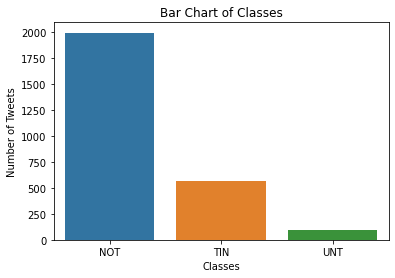

In [37]:
sns.countplot(df_test.predicted_class)
plt.xlabel('Classes');
plt.ylabel('Number of Tweets')
plt.title('Bar Chart of Classes')

In [39]:
df_test.to_csv('predicted_test.tsv', sep='\t', index = False)